In [1]:
# Importieren der benötigten Bibliotheken

# Datenmanipulation
import pandas as pd
import pickle

# Visualisierung
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

# Finales Modell: Hyperparameter Tuning


In [2]:
# Einlesen der Trainings- und Testdaten
destination_path = "../data/processed"

features_train = pd.read_csv(f"{destination_path}/features_train.csv")
features_test = pd.read_csv(f"{destination_path}/features_test.csv")
target_train = pd.read_csv(f"{destination_path}/target_train.csv")
target_test = pd.read_csv(f"{destination_path}/target_test.csv")

# Zielvariablen in einem Dictionary organisieren
targets = {
    "compressor": {
        "train": target_train.iloc[:, 0],
        "test": target_test.iloc[:, 0]
    },
    "turbine": {
        "train": target_train.iloc[:, 1],
        "test": target_test.iloc[:, 1]
    }
}

**Feature Engineering**


In [3]:
def engineer_features(df):
    '''
    - Neue Features zum DataFrame hinzufügen.

    Args:
        df (pd.DataFrame): DataFrame.

    Returns:
        pd.DataFrame: DataFrame mit zusätzlichen Features.
    '''
    
    df_engineer = df.copy()
    df_engineer["compressor_ratio"] = df["GT_Compressor_outlet_air_pressure_(P15)_[bar]"] / df["GT_Compressor_inlet_air_pressure_(P1)_[bar]"]

    return df_engineer

**Feature Selection**


In [4]:
# Auswahl der Features basierend auf den Ergebnissen aus 03_baseline_model.ipynb
important_features = [
    "gt_compressor_outlet_air_temperature_t2_c",
    "gas_turbine_gt_shaft_torque_gtt_kn_m",
    "gt_compressor_outlet_air_pressure_p2_bar"
]

features_train_select = features_train[important_features]
features_test_select = features_test[important_features]

**Hyperparameter-Optimierung mit GridSearchCV**


In [5]:
# Parameter-Grid für den Random Forest
param_grid = {
    'n_estimators': [100, 200, 400],
    'max_depth': [None, 20, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

best_models = {}

# Schleife für Kompressor und Turbine
for target_name, target_data in targets.items():
    print(f"GridSearchCV für: {target_name}")

    rf = RandomForestRegressor(random_state=42) # Initialisiere das Modell
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, scoring='r2') # Initialisiere die Grid Search
    grid_search.fit(features_train_select, target_data["train"]) # Führe die Grid Search durch
    best_models[target_name] = grid_search.best_estimator_ # Speichere das beste Modell
    
    print(f"Beste Parameter: {grid_search.best_params_}")
    print(f"Bester R2 (CV): {grid_search.best_score_:.4f}\n")

GridSearchCV für: compressor
Beste Parameter: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}
Bester R2 (CV): 0.9967

GridSearchCV für: turbine
Beste Parameter: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}
Bester R2 (CV): 0.9684



**Finale Evaluation und Speicherung**


Finale Performance compressor auf Test-Set
R2 Score: 0.9975

Finale Performance turbine auf Test-Set
R2 Score: 0.9713



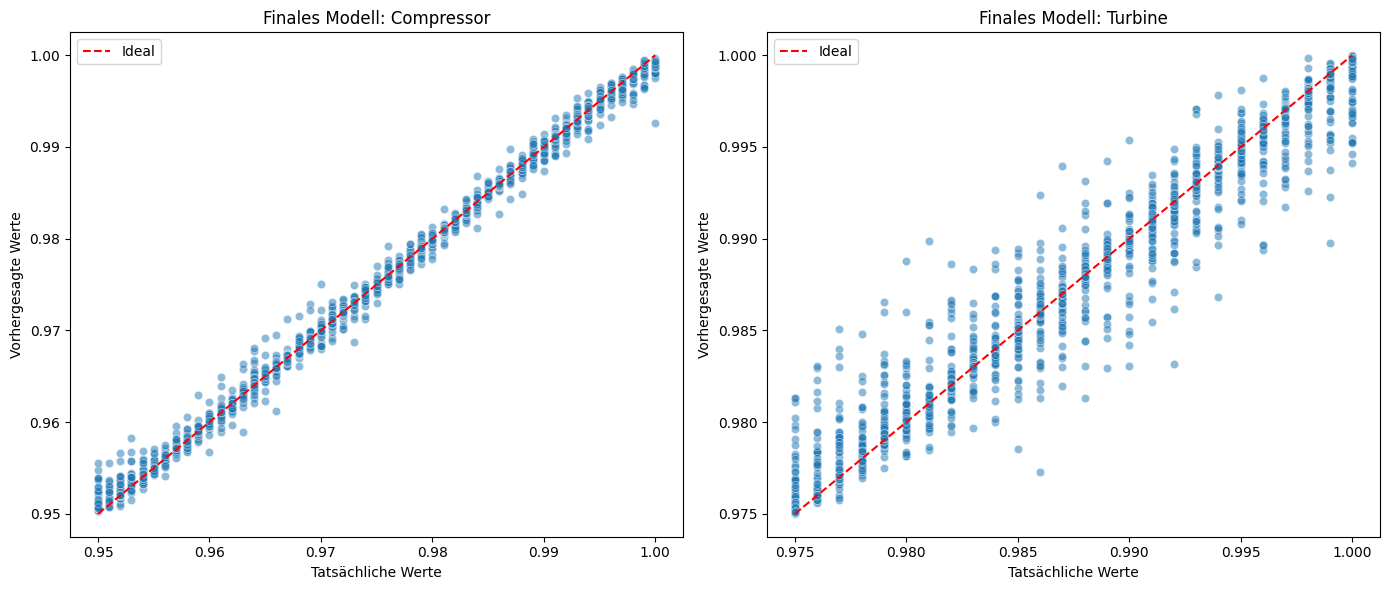

In [6]:
# Evaluieren und Speichern der optimierten Modelle
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Schleife für Kompressor und Turbine
for i, (target_name, best_model) in enumerate(best_models.items()):
    # Vorhersagen auf dem Test-Set
    predictions = best_model.predict(features_test_select)
    r2 = r2_score(targets[target_name]['test'], predictions)
    
    print(f"Finale Performance {target_name} auf Test-Set")
    print(f"R2 Score: {r2:.4f}\n")
    
    # Speichern des Modells
    with open(f"../data/models/final_model_{target_name}.pkl", "wb") as file:
        pickle.dump(best_model, file)

    # Visualisierung der Vorhersagen
    ax = axes[i]
    sns.scatterplot(x=targets[target_name]["test"], y=predictions, alpha=0.5, ax=ax)

    ax.plot([targets[target_name]["test"].min(), targets[target_name]["test"].max()], 
             [targets[target_name]["test"].min(), targets[target_name]["test"].max()], 'r--', label='Ideal')
    ax.set_title(f'Finales Modell: {target_name.capitalize()}')
    ax.set_xlabel('Tatsächliche Werte')
    ax.set_ylabel('Vorhergesagte Werte')
    ax.legend()

plt.tight_layout()
plt.show()